In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Get a list of column names and types for measurement
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Get a list of column names and types for station
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
def dateadd(datepart, number, date):
    """
    Args:
        datepart (string): Which date part to be added/substracted from
        number (int): Possitive or negative units to move the date to
        date (string): Date value to modify in format %Y-%m-%d
        
    Returns:
        date in format %Y-%m-%d
    """
    
    if (datepart == 'd' or datepart == 'day'):
        multiplier = 1                             # if adding day use the value of number
    elif (datepart == 'w' or datepart == 'week'):
        multiplier = 7                             # if adding week multiply by 7 
    elif (datepart == 'm' or datepart == 'month'):
        multiplier = 30                            # if adding month multiply by 30
    elif (datepart == 'y' or datepart == 'year'):
        multiplier = 365                           # if adding year multiply by 365
    
    number *= multiplier
    
    return (dt.datetime.strptime(date,"%Y-%m-%d").date() + \
            dt.timedelta(days=number)).strftime("%Y-%m-%d")

#function usage sample: 
#return one year ago
print(f"One year ago: {dateadd('y', -1, '2017-08-23')}")
#return 3 weeks from     

One year ago: 2016-08-23


2016-08-23
SELECT measurement.date, measurement.prcp AS precipitation 
FROM measurement 
WHERE measurement.date >= :date_1 ORDER BY measurement.date


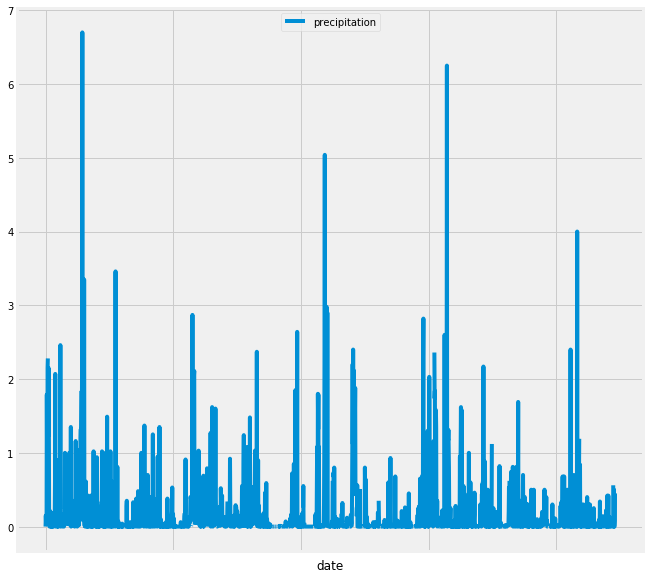

In [14]:
# Calculate the date 1 year ago from the last data point in the database
year_ago = dateadd('y', -1 , session.query(Measurement.date).\
                             order_by(Measurement.date.desc()).first()[0])
print(year_ago)

# Design a query to retrieve the last 12 months of precipitation data and plot the results
select_stmt = session.query(Measurement.date, Measurement.prcp.label("precipitation")).\
    filter(Measurement.date>=year_ago).\
    order_by(Measurement.date).statement
print(select_stmt)

# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_scores = pd.read_sql(select_stmt, session.bind).\
                reset_index(None)[["date","precipitation"]] 

# Sort the dataframe by date
prcp_scores.set_index("date", inplace=True) 

# Use Pandas Plotting with Matplotlib to plot the data
plt_score = prcp_scores.plot(figsize=(10,10))
plt_score.legend(loc="upper center")
plt.savefig("plot_last_12_months_precipitation.png")
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_scores.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.id)).all()

[(9)]

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.id)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.id).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs),\
              func.max(Measurement.tobs),\
              func.avg(Measurement.tobs)).\
              filter(Measurement.station=='USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

SELECT measurement.station, measurement.tobs 
FROM measurement 
WHERE measurement.date >= :date_1 AND measurement.station = :station_1


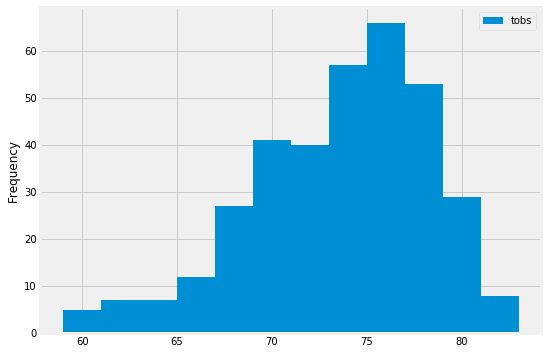

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

select_stmt = session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.date>=year_ago).\
    filter(Measurement.station=='USC00519281').\
    statement
print(select_stmt)
temp_observations = pd.read_sql(select_stmt, session.bind).\
                    reset_index(None)[["station","tobs"]]
temp_observations.set_index("station")
hist_plot = temp_observations.plot.hist(bins=12,figsize=(8,6))
plt.savefig("histogram_temperature_observations.png")
plt.show()

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# trip start and end date
trip_start = '2017-02-28'
trip_end = '2017-03-11'
trip_temp = calc_temps(dateadd('y',-1,trip_start), \
                       dateadd('y',-1,trip_end))
trip_temp
#[(62.0, 70.94594594594595, 82.0)]

[(62.0, 70.11392405063292, 79.0)]

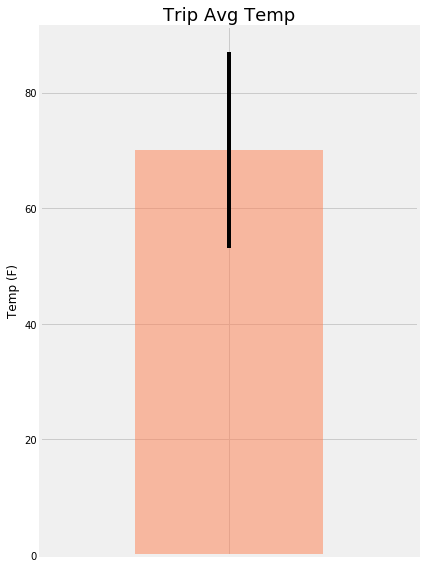

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

avg_temp = pd.DataFrame([trip_temp[0][1]],columns=["Avg Temp"])
error = trip_temp[0][2]-trip_temp[0][0]

bar_plot = avg_temp.plot(kind="bar", \
                         yerr=error, \
                         alpha=0.5, \
                         color="coral", \
                         figsize=(6,8), \
                         legend=None)

bar_plot.axes.xaxis.set_ticklabels([])
plt.title("Trip Avg Temp", fontsize=18)
plt.ylabel("Temp (F)")

# Save the figure and show
plt.tight_layout()
plt.savefig('bar_trip_average_temp.png')
plt.show()

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation 

sel =[Measurement.station, \
      Station.name, \
      Station.latitude, \
      Station.longitude, \
      Station.elevation, \
      func.sum(Measurement.prcp).label("total rain fall") ]

select_stmt = session.query(*sel).\
                filter(Measurement.station == Station.station).\
                filter(Measurement.date >= dateadd('y',-1,trip_start)).\
                filter(Measurement.date <= dateadd('y',-1,trip_end)).\
                group_by(Measurement.station).\
                order_by(func.sum(Measurement.prcp).desc()).\
                statement
print(select_stmt)
print(f"trip start date: {dateadd('y',-1,trip_start)}\ntrip end date: {dateadd('y',-1,trip_end)}")
rainfall_trip = pd.read_sql(select_stmt, session.bind)
rainfall_trip

SELECT measurement.station, station.name, station.latitude, station.longitude, station.elevation, sum(measurement.prcp) AS "total rain fall" 
FROM measurement, station 
WHERE measurement.station = station.station AND measurement.date >= :date_1 AND measurement.date <= :date_2 GROUP BY measurement.station ORDER BY sum(measurement.prcp) DESC
trip start date: 2016-02-29
trip end date: 2016-03-11


,station,name,latitude,longitude,elevation,total rain fall
0,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.65
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.38
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.37
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.35
4,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.23
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.19
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

# Modified the original function to make it more felxible
def period_normals(dateformat,date):
    """Daily Normals.
    
    Args:
        dateformat (str): Format to be used for querying the data:
            . '%Y-%m'
            . '%m-%d'
            . '%m'
        date (str): A date string in the format dateformat
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime(dateformat, Measurement.date) == date).all()

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

start_date = dt.datetime.strptime(trip_start,"%Y-%m-%d")
end_date = dt.datetime.strptime(trip_end,"%Y-%m-%d")
dateformat = "%m-%d"
normals = [period_normals(dateformat,dt.date.fromordinal(i).strftime(dateformat))[0] \
           for i in range(start_date.toordinal(), end_date.toordinal())]


In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_dates = [dt.date.fromordinal(i).strftime("%Y-%m-%d") \
              for i in range(start_date.toordinal(), end_date.toordinal())]
print(trip_dates)
trip_daily = pd.concat([pd.DataFrame(trip_dates,columns=["date"]),\
                        pd.DataFrame(normals, \
                                    columns=["tmin", "tavg", "tmax"])]\
                       ,axis=1).reset_index(None)[["date","tmin", "tavg", "tmax"]]
trip_daily.set_index("date", inplace=True)
trip_daily.head()

['2017-02-28', '2017-03-01', '2017-03-02', '2017-03-03', '2017-03-04', '2017-03-05', '2017-03-06', '2017-03-07', '2017-03-08', '2017-03-09', '2017-03-10']


,tmin,tavg,tmax
date,,,
2017-02-28,65.0,70.655172,80.0
2017-03-01,64.0,70.032787,76.0
2017-03-02,61.0,70.366667,78.0
2017-03-03,60.0,70.068966,78.0
2017-03-04,57.0,69.272727,77.0


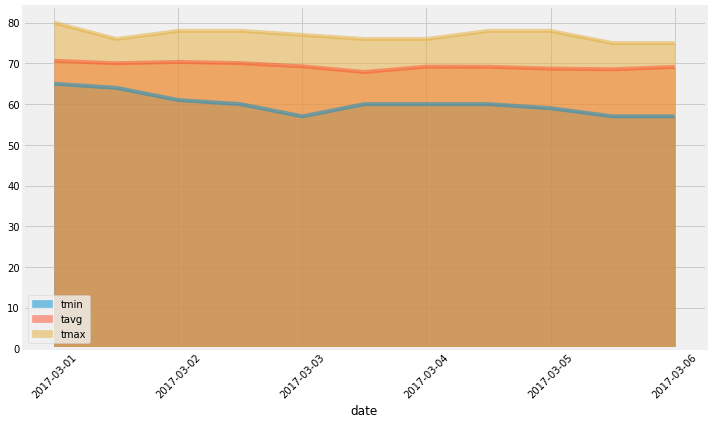

In [27]:
# Plot the daily normals as an area plot with `stacked=False`
area_plot = trip_daily.plot(kind="area",stacked=False, figsize=(10,6))
area_plot.axes.xaxis.set_ticklabels(trip_dates, rotation=45)
#plt.xlim(1,12)
plt.tight_layout()
plt.savefig("area_trip_daily_temp.png")
plt.show()

### Optional analysis

Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?

A paired t-test was used to analyze the 2 samples because the 2 samples are related; they contain the average temperature readings for all 9 stations for 2 different months: June and December.

The pvalue of the ttest is 0.00011759380231523222 which indicates there is meaningful difference between the temperatures for the months of June and December. In other words, the chances of seeing a large difference between average temperatures of both months due to chance is 0.012%.  


In [28]:
select_stmt = session.query(Measurement.station, func.avg(Measurement.tobs).label("temperature")).\
    filter(func.strftime("%m", Measurement.date) == "06").\
    group_by(Measurement.station).\
    order_by(Measurement.station).statement
print(select_stmt)
june_reading = pd.read_sql(select_stmt, session.bind)
june_reading

SELECT measurement.station, avg(measurement.tobs) AS temperature 
FROM measurement 
WHERE strftime(:strftime_1, measurement.date) = :strftime_2 GROUP BY measurement.station ORDER BY measurement.station


,station,temperature
0,USC00511918,74.139394
1,USC00513117,74.050847
2,USC00514830,76.005376
3,USC00516128,71.937220
4,USC00517948,76.655405
5,USC00518838,73.394737
6,USC00519281,73.271186
7,USC00519397,77.559322
8,USC00519523,76.668103


In [29]:
select_stmt = session.query(Measurement.station, func.avg(Measurement.tobs).label("temperature")).\
    filter(func.strftime("%m", Measurement.date) == "12").\
    group_by(Measurement.station).\
    order_by(Measurement.station).statement
print(select_stmt)
dec_reading = pd.read_sql(select_stmt, session.bind)
dec_reading

SELECT measurement.station, avg(measurement.tobs) AS temperature 
FROM measurement 
WHERE strftime(:strftime_1, measurement.date) = :strftime_2 GROUP BY measurement.station ORDER BY measurement.station


,station,temperature
0,USC00511918,69.684211
1,USC00513117,71.069444
2,USC00514830,73.224719
3,USC00516128,69.291262
4,USC00517948,71.834862
5,USC00518838,72.421053
6,USC00519281,69.903226
7,USC00519397,71.109524
8,USC00519523,72.433333


In [30]:
stats.ttest_rel(june_reading["temperature"],dec_reading['temperature'])

Ttest_relResult(statistic=6.95696617044294, pvalue=0.00011759380231523222)

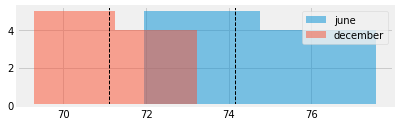

In [31]:
plt.subplot(2, 1, 2)
plt.hist(june_reading["temperature"], "fd", density=False, alpha=0.5, label="june")
plt.hist(dec_reading["temperature"], "fd", density=False, alpha=0.5, label="december")
plt.axvline(june_reading["temperature"].median(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(dec_reading["temperature"].median(), color='k', linestyle='dashed', linewidth=1)
plt.legend()  
plt.savefig("histogram_June_Dec_avg_temp.png")
plt.show()